# Sentimen Analysis From Reviews Users to Mitra

Tim Machine Learning (ML) membangun model Natural Language Processing (NLP) untuk memprediksi sentimen dari ulasan pelanggan. Hasil keseluruhan sentimen tersebut akan ditampilkan di dashboard mitra, sehingga mitra dapat memantau presentase kepuasan pelanggan. Tujuannya adalah agar mitra dapat mengevaluasi produknya berdasarkan data sentimen pelanggan yang terdeteksi oleh model NLP tersebut.

## Import Library

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re
import nltk
import string
import json
from textblob import TextBlob
nltk.download('punkt')
from nltk.corpus import stopwords
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from google.colab import files

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Import Datasets

In [ ]:
!git clone https://github.com/kzquandary/ch2-ps030.git

Cloning into 'ch2-ps030'...
remote: Enumerating objects: 488, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 488 (delta 30), reused 58 (delta 22), pack-reused 397
Receiving objects: 100% (488/488), 6.39 MiB | 24.79 MiB/s, done.
Resolving deltas: 100% (105/105), done.


In [ ]:
datasets = '/content/ch2-ps030/ML/datasets - reviews.csv'
df = pd.read_csv(datasets)
df

,ulasan,sentimen,rating
0,Saya baru mencoba minuman dari gerai ini. Minu...,netral,3.0
1,Makanan ini sangat mengecewakan. Rasanya terla...,negative,2.0
2,memiliki cita rasa yang unik. Perpaduan antara...,positive,5.0
3,Saya sangat merekomendasikan makanan ini kepad...,positive,5.0
4,Pelayanan di warung ini cukup ramah dan efisie...,netral,3.0
...,...,...,...
670,Saya datang kesini coba menu ayam goreng telur...,netral,3.0
671,"Makanan cukup enak, harga ya lumayan.. Tapi pe...",netral,3.0
672,"Rasa makanan gak seenak dulu, atau mungkin kar...",netral,3.0
673,"Tidak terlalu spesial, terutama ikan bakarnya....",netral,3.0


## Cleaning Data

Pada bagian ini dilakukan pengecekan data yang terdiri dari tipe data dari setiap kolomnya, memeriksa apakah terdapat data yang kosong, dan data yang mengalami duplikasi.

In [ ]:
#cek class pada data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ulasan    675 non-null    object 
 1   sentimen  675 non-null    object 
 2   rating    675 non-null    float64
dtypes: float64(1), object(2)
memory usage: 15.9+ KB


Dari data diatas dapat dilihat bahwa jenis data untuk kolom 'ulasan' dan 'sentimen' adalah object atau bisa dikatakan sebuah string, sedangkan kolom rating sudah benar yaitu berupa float dengan tipe float 64 bit. Selanjutnya akan di cek apakah ada data yang kosong (null)

In [ ]:
#cleaning data
df.isnull().sum()

ulasan      0
sentimen    0
rating      0
dtype: int64

Dapat dilihat bahwa tidak terdapat data yang kosong(null)

In [ ]:
df.duplicated().sum()

4

Kemudian, dilakukan pengecekan apakah datasets terdapat data yang redundan dan dapat dilihat bahwa terdapat 4 data yang mengalami redundansi

In [ ]:
#remove duplicate
data = df.drop_duplicates()
print(data)

                                                ulasan  sentimen  rating
0    Saya baru mencoba minuman dari gerai ini. Minu...    netral     3.0
1    Makanan ini sangat mengecewakan. Rasanya terla...  negative     2.0
2    memiliki cita rasa yang unik. Perpaduan antara...  positive     5.0
3    Saya sangat merekomendasikan makanan ini kepad...  positive     5.0
4    Pelayanan di warung ini cukup ramah dan efisie...    netral     3.0
..                                                 ...       ...     ...
670  Saya datang kesini coba menu ayam goreng telur...    netral     3.0
671  Makanan cukup enak, harga ya lumayan.. Tapi pe...    netral     3.0
672  Rasa makanan gak seenak dulu, atau mungkin kar...    netral     3.0
673  Tidak terlalu spesial, terutama ikan bakarnya....    netral     3.0
674  Makanan enak, sambel gratisnya mantab, sayang ...    netral     3.0

[671 rows x 3 columns]


Selanjutnya, dilakukan penghapusan terhadap data yang mengalami duplikasi.

In [ ]:
df = data.copy()
def normalize_text(text):
  text = text.lower()  # Mengubah semua karakter menjadi huruf kecil
  text = text.strip(" ") # Menghapus spasi di awal dan akhir teks
  text = re.sub(r'[?|$|.|!_:")(-+,]', '', text) # Menghapus karakter khusus seperti ?, $, ., !, _, dll.
  text = re.sub(r'\d+', '', text) # Menghapus angka
  text = re.sub(r'[^a-zA-Z. ]', '', text) # Menghapus karakter selain huruf dan spasi
  text = re.sub(r'\s+', ' ', text) # Menggantikan beberapa spasi berturut-turut dengan satu spasi
  text = re.sub(r'(\w)\1{1,}', r'\1\1', text)  # Normalisasi huruf berlebihan
  return text

df['clean_teks'] = df['ulasan'].apply(normalize_text)
df.head(10)

,ulasan,sentimen,rating,clean_teks
0,Saya baru mencoba minuman dari gerai ini. Minu...,netral,3.0,saya baru mencoba minuman dari gerai ini minum...
1,Makanan ini sangat mengecewakan. Rasanya terla...,negative,2.0,makanan ini sangat mengecewakan rasanya terlal...
2,memiliki cita rasa yang unik. Perpaduan antara...,positive,5.0,memiliki cita rasa yang unik perpaduan antara ...
3,Saya sangat merekomendasikan makanan ini kepad...,positive,5.0,saya sangat merekomendasikan makanan ini kepad...
4,Pelayanan di warung ini cukup ramah dan efisie...,netral,3.0,pelayanan di warung ini cukup ramah dan efisie...
5,tempat yang layak untuk mencoba minuman segar ...,netral,3.0,tempat yang layak untuk mencoba minuman segar ...
6,Makanan ini memiliki rasa yang unik dan tidak ...,positive,4.0,makanan ini memiliki rasa yang unik dan tidak ...
7,Pilihan yang sangat baik untuk camilan sehat s...,positive,4.0,pilihan yang sangat baik untuk camilan sehat s...
8,"Inovatif dan beragam, selalu ada sesuatu yang ...",positive,4.0,inovatif dan beragam selalu ada sesuatu yang b...
9,"Tidak mengecewakan, harganya juga terjangkau.",positive,4.0,tidak mengecewakan harganya juga terjangkau


Pada kode diatas kami melakukan cleaning data diantaranya seperti mengubahnya menjadi huruf kecil, menghapus white space, menghapus karakter khusus (? < : ! @ # dll), menghapus angka, menghapus karakter selain huruf dan spasi, Menggantikan beberapa spasi berturut-turut dengan satu spasi, dan Normalisasi huruf berlebihan.

In [ ]:
!gdown --id 1u3__x8f28W8snXi8HwkZjwt5kR6fEsae

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1u3__x8f28W8snXi8HwkZjwt5kR6fEsae
To: /content/slang.txt
100% 39.4k/39.4k [00:00<00:00, 95.6MB/s]


Kode diatas digunakan untuk mengambil file slang.txt dimana file tersebut berisi kumpulan kata-kata yang memiliki singkatan seperti 'yg' akan dikembalikan menjadi 'yang'. Tahap ini merupakan normalisasi kata-kata.

In [ ]:
slangs = open('slang.txt',"r",encoding="utf-8", errors='replace')

clear_slangs= []
for newlines in slangs:
  strip_re = newlines.strip("\n")
  split = re.split(r'[:]',strip_re)
  clear_slangs.append(split)
clear_slangs[:5]

[['& ', ' dan'],
 ['dr ', ' dari'],
 ['abis ', ' habis'],
 ['ad ', ' ada'],
 ['alhmdulillah ', ' alhamdulillah']]

In [ ]:
slangs = [[k.strip(), v.strip()] for k,v in clear_slangs]
dict_slangs = {key:values for key,values in slangs}

In [ ]:
clean_text = []
for text in df['clean_teks']:
  wordlist = TextBlob(text).words
  for k,v in enumerate(wordlist):
    if v in dict_slangs.keys():
      wordlist[k] = dict_slangs[v]
  clean_text.append(' '.join(wordlist))

df['normalization'] = clean_text
df.head(10)

,ulasan,sentimen,rating,clean_teks,normalization
0,Saya baru mencoba minuman dari gerai ini. Minu...,netral,3.0,saya baru mencoba minuman dari gerai ini minum...,saya baru mencoba minuman dari gerai ini minum...
1,Makanan ini sangat mengecewakan. Rasanya terla...,negative,2.0,makanan ini sangat mengecewakan rasanya terlal...,makanan ini sangat mengecewakan rasanya terlal...
2,memiliki cita rasa yang unik. Perpaduan antara...,positive,5.0,memiliki cita rasa yang unik perpaduan antara ...,memiliki cita rasa yang unik perpaduan antara ...
3,Saya sangat merekomendasikan makanan ini kepad...,positive,5.0,saya sangat merekomendasikan makanan ini kepad...,saya sangat merekomendasikan makanan ini kepad...
4,Pelayanan di warung ini cukup ramah dan efisie...,netral,3.0,pelayanan di warung ini cukup ramah dan efisie...,pelayanan di warung ini cukup ramah dan efisie...
5,tempat yang layak untuk mencoba minuman segar ...,netral,3.0,tempat yang layak untuk mencoba minuman segar ...,tempat yang layak untuk mencoba minuman segar ...
6,Makanan ini memiliki rasa yang unik dan tidak ...,positive,4.0,makanan ini memiliki rasa yang unik dan tidak ...,makanan ini memiliki rasa yang unik dan tidak ...
7,Pilihan yang sangat baik untuk camilan sehat s...,positive,4.0,pilihan yang sangat baik untuk camilan sehat s...,pilihan yang sangat baik untuk camilan sehat s...
8,"Inovatif dan beragam, selalu ada sesuatu yang ...",positive,4.0,inovatif dan beragam selalu ada sesuatu yang b...,inovatif dan beragam selalu ada sesuatu yang b...
9,"Tidak mengecewakan, harganya juga terjangkau.",positive,4.0,tidak mengecewakan harganya juga terjangkau,tidak mengecewakan harganya juga terjangkau


Dapat dilihat terdapat kolom baru bernama 'normalization' yang berisi kalimat di kolom 'ulasan' yang telah dinormalisasi.

In [ ]:
stopwords = [
    "nya", "duarebuan", "berarti", "lo", "sakit", "jiwa", "ye", "kan", "broh", "sist", "ugh", "bebashzz", "per",
    "yekan", "yang", "saya", "dia", "dan", "terlihat", "tergesa-gesa", "nilai", "dari",
    "pengalaman", "ini", "semakin", "duh", "kikilnya", "crowded", "obat", "mie kocok", "biarpun",
    "kaki", "lima", "mie", "siomay", "batagor", "dimsum", "sate", "di" "atas", "siapa pun", "siapa",
    "di", "restoran", "ini", "di", "sini", "benar-benar", "pertama-tama", "ke" "sini", "roast", "potato", "pork", "pricey",
    "ombe", "big", "breakfast", "baksonya", "cuanki", "bumbu", "kacang", "cilung", "eskrimnya", "rendang", "mi", "aceh", "gudeg",
    "seblak", "gorengannya", "ricebowl", "isian ayamnya", "sayuran", "basreng", "pedes", "sate daging",
    "ciloknya","bumbu","es teh", "nasi goreng", "soto ayam", "kripik", "singkong", "cakue", "tahu bulat",
    "sotong", "rotinya", "singkong", "segi", "plating", "gado-gado","pempek","udang", "cumi", "goreng", "tepung", "kangkung", "tauco", "sama", "istri",
    "ikan", "bakar", "bakso", "khas", "wonogiri", "kuning", "bogor", "nih", "minyak", "samin", "duhhh", "nan", "perkedel",
    "babat", "paru", "empal", "camilan", "dr", "ke", "hehe", "tumis", "dadaknya", "baso", "kaldu",
    "sumsum-nya", "abissss", "bihun", "pangsit", "sagu", "kasta", "kuy", "cuss", "mienya", "bening",
    "keruh", "keripik", "tukang", "gali", "haha", "loading", "kebulinya", "acarnya", "kerupuk", "kebuli",
    "bakmi", "pcs", "dimsumnya", "cabenya", "lengkuas", "potongan", "dada", "berserat", "dg", "utk",
    "cemilannya", "lumpia", "udangnya", "pd", "jawa", "timur", "jakarta", "cingurnya", "rujak", "cingur"
    "doger", "genjer", "lamongan", "sekutengnya", "gudeg", "kecombrangnya", "mendoannya", "fuyung", "hai",
    "mentege", "pepes", "gudegnya", "kreceknya", "krecek", "benyek", "taliwangnya", "plecingnya",
    "jagungnya", "barendo", "dendengnya", "dendeng", "ijo", "merah", "beras", "pera", "balado",
    "kembung", "yaaa", "deh", "guyss", "sip", "wow", "kredok", "liwetnya", "pesmol", "samosa",
    "roti", "capatinya", "samosanya", "bubur", "briyaninya", "canay", "maryamnya", "kopi" ,"pakistannya",
    "pasta", "spaghettinya", "ifumie", "pastanya", "carbonara", "sauce", "capcay", "kentang", "teh",
    "smoked", "beef", "pizza", "spicy" , "tunanya", "huhuhu", "kopinya", "hazelnut", "chococino",
    "seafoodnya", "salted", "egg", "kerang", "bawang", "putihnya", "sekel", "cangkang", "mangut",
    "garang", "asemnya", "andaliman", "tapanuli", "rumah", "bpk", "batak", "the", "lah", "ini",
    "keju", "kejunya", "boba", "sedotannya", "topping", "mika", "sterofoam", "siomay", "pangsitnya",
    "somay", "mango", "tea", "dinasgor", "suiran", "gotengnya", "ati", "seblak-seblaknya", "gelasnya",
    "jahenya", "timun", "tomat", "chickennya", "cupnya", "tutup", "batu", "mah", "laper-lapernya", "sambel", "sayang", "ikan", "bakar", "ikannya", "ayam", "goreng", "telur",
    "hmmm", "awalnya", "kirain", "ternyata", "bakar", "madu", "sambal", "merahnya",
    "minuman", "buah", "markisa", "ala-ala", "bali", "rempah", "bakso", "penyet",
    "tangsel", "nemunya", "pecel", "lele", "sambal", "sop", "iga", "rebus", "dagingnya",
    "sepiring", "nasi", "bebek", "kremes", "gorengnya", "makanannya", "cumi", "rempah",
    "tepung", "dah", "karedok", "udang", "gandum", "tahu", "kipas", "jamur", "crispy", "kuwe",
    "ekor", "udang", "rebon", "kalasan", "gurame", "pecak", "soto", "daging", "tempe", "otak-otak",
    "asam", "manis", "pedes", "sotonya", "kangkung", "udang", "bacem", "nasi", "pecak", "betawi",
    "mie", "milkshake", "cokelat", "kulit", "mayonaise", "patin", "cabut", "duri", "durinya",
    "sayur", "asemnya", "empalnya", "buntut", "warsun", "buntutnya", "bonggol", "bonggolnya",
    "air", "tawar", "kerupuk", "gendar", "mi", "jogja", "dll", "tengkleng", "serabi", "solo",
    "sate", "maranggi", "selad", "mendoany", "jawa", "gudeg", "teh", "sereh", "wedang", "jahe",
    "susu", "cendol", "liwet", "sego", "daun", "pisang", "pakai", "lele", "buntel", "lilit",
    "roti", "bebek", "bebeknya", "yekaann", "masnua", "mbak", "es", "kelapa", "gelas", "XL",
    "stelah", "rujak", "buah", "buahnya", "bakso", "cuanki", "kuahnya", "isian", "martabaknya",
    "bumbu", "martabak", "kripik", "singkongnya", "alpukat", "kocoknya", "gula", "arennya",
    "kuahnya", "baksonya", "kejunya", "dimsumnya", "vegetarian", "rotinya", "gulungnya", "krimnya",
    "creamy", "gejrotnya", "kuah", "digoreng", "kental", "ketopraknya", "lontong", "kerak", "cirengnya",
    "jeruknya", "kacangnya", "pempeknya", "saus", "cuko", "seblak", "bulatnya", "salad", "sayur",
    "basonya", "rendang", "gado", "sayurnya", "lada", "gorengan", "gorengannya", "Djakarta", "paket",
    "kepiting", "padang", "dua", "ekor", "macam-macam", "tumisan", "usus", "kerang", "burgernya",
    "nasinya", "kelapa", "campurnya", "kelapanya", "sayuran", "sachet", "ya", "kebabnya", "kulit",
    "doang", "lagi", "cabenya", "paha", "atas", "bawah", "pastelnya", "isinya", "bakwan", "rebonnya",
    "terinya", "lalapannya", "yah", "udangnya", "tiramnya", "terong", "baladonya", "dadar", "mas",
    "mak", "nyoss", "sukss", "kebulinya", "potatonya", "rempah-rempahnya", "jus", "jeruk", "kue",
    "rp", "ya", "hmm", "adalah", "nya", "baliqui", "gintung", "dong", "sih", "di", "dari", "lah", "an", "oiya",
    "yekaann", "kali", "xl", "kaula", "ribu", "is", "the", "top", "nyoss", "mah", "wkwkwk", "ngikan", "huhuhu",
    "guyss", "deh", "ber", "pun", "gofood", "grabfood", "grabcar", "haha", "karbohidrat", "weekend", "cuss",
    "duhh", "nan", "wkwkk", "guys", "tu", "pejabat", "gez", "wuuiih", "x", "mleber", "btw", "hehe", "hahaha",
    "yahh", "kamiaremnya", "cincinnya", "lah", "kg", "ih", "kok", "dua", "ribuan", "yekan", "sist", "bro", "mba", "mas", "pak"
]

def remove_stopwords(text):
  final_text = []
  for word in text.split():
    if word.strip().lower() not in stopwords:
      final_text.append(word.strip().lower())
  return " ".join(final_text)

Pada kode diatas kami membuat list kata-kata yang tidak memiliki pengaruh terhadap penentuan sentimen dan kami juga membuat fungsi bernama remove_stopwords() yang berfungsi untuk menghapus kata-kata yang terdapat dilist yang telah kami buat.

In [ ]:
example = "langganan aku, cuss pada beli, bakso terenak"
print(remove_stopwords(example))

langganan aku, pada beli, terenak


In [ ]:
df['normalization'] = df['normalization'].apply(lambda x: remove_stopwords(x))

fungsi remove_stopwords() diterapkan pada kolom 'normalization'.

In [ ]:
df['reviews'] = df['normalization']
df

,ulasan,sentimen,rating,clean_teks,normalization,reviews
0,Saya baru mencoba minuman dari gerai ini. Minu...,netral,3.0,saya baru mencoba minuman dari gerai ini minum...,baru mencoba gerai pesan segar rasanya lumayan...,baru mencoba gerai pesan segar rasanya lumayan...
1,Makanan ini sangat mengecewakan. Rasanya terla...,negative,2.0,makanan ini sangat mengecewakan rasanya terlal...,makanan sangat mengecewakan rasanya terlalu as...,makanan sangat mengecewakan rasanya terlalu as...
2,memiliki cita rasa yang unik. Perpaduan antara...,positive,5.0,memiliki cita rasa yang unik perpaduan antara ...,memiliki cita rasa unik perpaduan antara rasa ...,memiliki cita rasa unik perpaduan antara rasa ...
3,Saya sangat merekomendasikan makanan ini kepad...,positive,5.0,saya sangat merekomendasikan makanan ini kepad...,sangat merekomendasikan makanan kepada anda ya...,sangat merekomendasikan makanan kepada anda ya...
4,Pelayanan di warung ini cukup ramah dan efisie...,netral,3.0,pelayanan di warung ini cukup ramah dan efisie...,pelayanan warung cukup ramah efisien waktu tun...,pelayanan warung cukup ramah efisien waktu tun...
...,...,...,...,...,...,...
670,Saya datang kesini coba menu ayam goreng telur...,netral,3.0,saya datang kesini coba menu ayam goreng telur...,datang coba menu asin dibalut asin tapi asinny...,datang coba menu asin dibalut asin tapi asinny...
671,"Makanan cukup enak, harga ya lumayan.. Tapi pe...",netral,3.0,makanan cukup enak harga ya lumayan tapi pelay...,makanan cukup enak harga lumayan tapi pelayana...,makanan cukup enak harga lumayan tapi pelayana...
672,"Rasa makanan gak seenak dulu, atau mungkin kar...",netral,3.0,rasa makanan gak seenak dulu atau mungkin kare...,rasa makanan tidak enak dahulu atau mungkin ka...,rasa makanan tidak enak dahulu atau mungkin ka...
673,"Tidak terlalu spesial, terutama ikan bakarnya....",netral,3.0,tidak terlalu spesial terutama ikan bakarnya s...,tidak terlalu spesial terutama bakarnya pesan ...,tidak terlalu spesial terutama bakarnya pesan ...


Kemudian, kalimat yang telah diterapkan fungsi remove_stopwords() disimpan pada kolom 'reviews'.

In [ ]:
data = df[['reviews','sentimen']]
data

,reviews,sentimen
0,baru mencoba gerai pesan segar rasanya lumayan...,netral
1,makanan sangat mengecewakan rasanya terlalu as...,negative
2,memiliki cita rasa unik perpaduan antara rasa ...,positive
3,sangat merekomendasikan makanan kepada anda ya...,positive
4,pelayanan warung cukup ramah efisien waktu tun...,netral
...,...,...
670,datang coba menu asin dibalut asin tapi asinny...,netral
671,makanan cukup enak harga lumayan tapi pelayana...,netral
672,rasa makanan tidak enak dahulu atau mungkin ka...,netral
673,tidak terlalu spesial terutama bakarnya pesan ...,netral


selanjutnya akan dipilih kolom yang diperlukan untuk dilakukan analisis sentimen, dimana pada kasus ini yang kami perlukan hanya kolom 'reviews' dan 'sentimen'.

## Split Datasets

In [ ]:
x_data = df['reviews']

new_idx_label = {
    'negative':0,
    'netral':1,
    'positive':2,
}
y_data = df['sentimen'].map(new_idx_label)
print(x_data, y_data)

0      baru mencoba gerai pesan segar rasanya lumayan...
1      makanan sangat mengecewakan rasanya terlalu as...
2      memiliki cita rasa unik perpaduan antara rasa ...
3      sangat merekomendasikan makanan kepada anda ya...
4      pelayanan warung cukup ramah efisien waktu tun...
                             ...                        
670    datang coba menu asin dibalut asin tapi asinny...
671    makanan cukup enak harga lumayan tapi pelayana...
672    rasa makanan tidak enak dahulu atau mungkin ka...
673    tidak terlalu spesial terutama bakarnya pesan ...
674    makanan enak gratisnya mantap kurang perhatian...
Name: reviews, Length: 671, dtype: object 0      1
1      0
2      2
3      2
4      1
      ..
670    1
671    1
672    1
673    1
674    1
Name: sentimen, Length: 671, dtype: int64


Kemudian kami memetakan label sentimen (positive, netral, negative) ke dalam angka (0,1,2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_data,
    y_data,
    stratify=y_data,
    test_size=0.2,
    random_state=42
)

Selanjutnya kami membagi datasets dimana sebanyak 20% dari data akan digunakan sebagai set validasi, sementara 80% akan digunakan sebagai set pelatihan.

## Tokenizing

kemudian kami melakukan penghitungan panjang maksimum dalam sebuah kata dari data pelatihan dan data validasi. lalu memilih kata yang lebih besar atau yang lebih panjang untuk penggunaan model.

In [ ]:
maxlen_train = x_train.map(
    lambda x: len(x.split())
)

# In Val Dataset
maxlen_val = x_val.map(
    lambda x: len(x.split())
)

maxlen = maxlen_train.max()

if (maxlen_train.max() < maxlen_val.max()):
    maxlen = maxlen_val.max()

print(maxlen)

75


lalu dilakukan tokenizing dengan panjang kata maksimum, selanjutnya mengonversi teks pelatihan ke indeks, dan terakhir mencetak jumlah kata yang unik.

In [ ]:
tokenizer = Tokenizer(
    num_words=maxlen,
    oov_token='<OOV>'
)
tokenizer.fit_on_texts(x_train.values)
word_index = tokenizer.word_index
print(len(word_index))

1638


selanjutnya membuat urutan token, melakukan padding pada data pelatihan dan data validasi dengan panjang maksimum, dengan menggunakan tokenizer sebelumnya dengan ukuran vokabuler 10,000 dan ukuran embedding 32.

In [ ]:
vocab_size = 10000
embed_size = 32
padding_type = 'post'

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_val_sequences = tokenizer.texts_to_sequences(x_val)

x_train_pad = pad_sequences(
    x_train_sequences,
    padding=padding_type,
    maxlen=maxlen
)

x_val_pad = pad_sequences(
    x_val_sequences,
    padding=padding_type,
    maxlen=maxlen
)


selanjutnya melakukan konversi teks ke urutan token, melakukan padding pada teks uji menggunakan tokenizer sebelumnya dengan panjang maksimum, dan menampilkan hasil dalam bentuk urutan token yang dipadatkan.

In [ ]:
text = "makanan ini sangat enak dan bergizi saya suka dan bakal menjadi langganan"
result = tokenizer.texts_to_sequences([text])
print(result)
test_pad = pad_sequences(
    tokenizer.texts_to_sequences([text]),
    padding=padding_type,
    maxlen=maxlen
)
print(len(test_pad))
print(test_pad);

[[13, 1, 12, 3, 1, 1, 1, 55, 1, 1, 1, 1]]
1
[[13  1 12  3  1  1  1 55  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]]


## Callback option

In [ ]:
class callback_acc(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc') > 0.995 or logs.get('val_acc') > 0.995):
      self.model.stop_training = True

callback_acc = callback_acc()
callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', restore_best_weights=True, patience=20)

Kode diatas merupakan callback yang berfungsi untuk menghentikan pelatihan model neural network jika akurasi pada data pelatihan (acc) atau akurasi pada data validasi (val_acc) mencapai nilai 0.995 atau lebih. Selain itu, kami juga menggunakan callback EarlyStopping untuk menghentikan pelatihan jika tidak terjadi peningkatan pada akurasi data validasi setelah 20 epoch berturut-turut.

## Modeling

Selanjutnya kami Membangun model neural network menggunakan lapisan embedding, global average pooling, dan beberapa lapisan Dense dengan fungsi aktivasi untuk klasifikasi tiga kelas. Output terakhir menggunakan fungsi aktivasi softmax dengan tiga kelas dengan hasil total parameter adalah 409,079.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_size, input_length=maxlen),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 75, 32)            320000    
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 500)               16500     
                                                                 
 dense_1 (Dense)             (None, 128)               64128     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                        

Selanjutnya model dikompilasi dengan fungsi kerugian sparse categorical crossentropy, pengoptimal Adam dengan learning rate sebesar 0.0001, dan metrik akurasi.

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['acc']
)

Model dilatih selama 100 epoch pada data pelatihan dan dievaluasi pada data validasi. Peningkatan akurasi terjadi pada epoch ke 62 dengan akurasi validasi sekitar 71.85%. Callback digunakan untuk pemantauan dan penghentian.

In [ ]:
history = model.fit(
    x_train_pad,
    y_train.values,
    epochs=100,
    batch_size=16,
    validation_data=(x_val_pad, y_val.values),
    callbacks=[callback_acc, callback_es],
    verbose=1
)

Epoch 1/100
34/34 [==============================] - 5s 80ms/step - loss: 1.0991 - acc: 0.3340 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 2/100
34/34 [==============================] - 1s 18ms/step - loss: 1.0986 - acc: 0.3340 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/100
34/34 [==============================] - 0s 14ms/step - loss: 1.0985 - acc: 0.3358 - val_loss: 1.0986 - val_acc: 0.3556
Epoch 4/100
34/34 [==============================] - 0s 14ms/step - loss: 1.0985 - acc: 0.3396 - val_loss: 1.0986 - val_acc: 0.4444
Epoch 5/100
34/34 [==============================] - 1s 20ms/step - loss: 1.0982 - acc: 0.4011 - val_loss: 1.0986 - val_acc: 0.3407
Epoch 6/100
34/34 [==============================] - 0s 13ms/step - loss: 1.0981 - acc: 0.3489 - val_loss: 1.0986 - val_acc: 0.3259
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 1.0980 - acc: 0.3414 - val_loss: 1.0985 - val_acc: 0.3259
Epoch 8/100
34/34 [==============================] - 0s 5ms/step - loss: 1.09

## Visualizations

Dengan menggunakan seaborn, diagram batang menunjukkan jumlah data untuk setiap sentimen. Diagram lingkaran menunjukkan persentase distribusi sentimen dalam dataset klasifikasi sentimen. Visualisasi memberikan gambaran visual tentang distribusi sentimen dalam dataset.

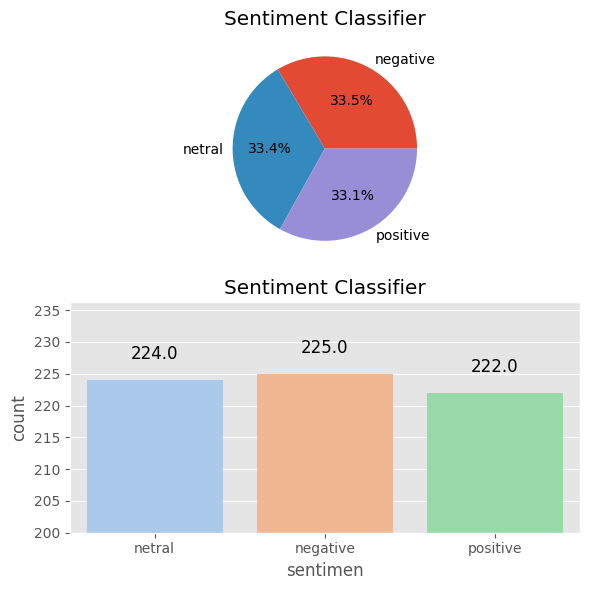

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

ax = sns.countplot(x='sentimen', data=data, palette="pastel")
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 3.25,rect.get_height(),horizontalalignment='center', fontsize = 12)
axes[1].set_title('Sentiment Classifier')
axes[1].set_ylim(200)

# hitung jumlah sentimen
sentiment_counts = data['sentimen'].value_counts()

# plot diagram lingkaran (pie chart)
axes[0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
axes[0].set_title('Sentiment Classifier')

plt.tight_layout()
plt.show()

Grafik di sebelah kiri menunjukkan kurva kerugian pelatihan dan validasi sepanjang epoch. Grafik di sebelah kanan menunjukkan kurva akurasi pelatihan dan validasi selama pelatihan model. Visualisasi ini membantu dalam evaluasi kinerja model.

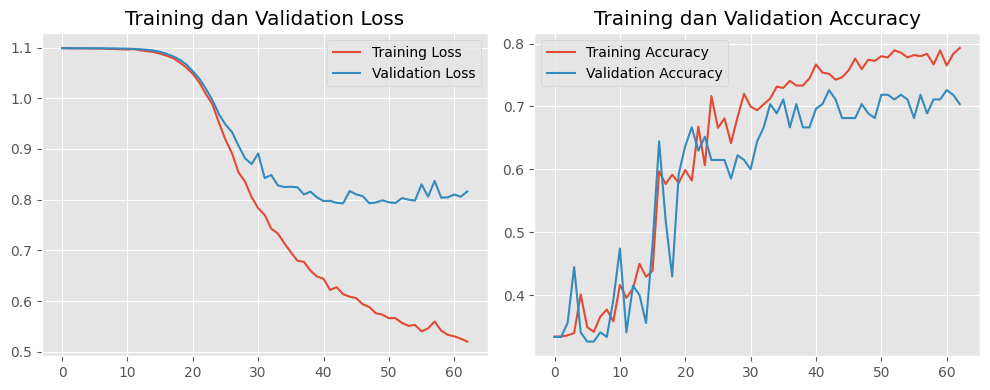

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].legend()
axes[0].set_title('Training dan Validation Loss')

axes[1].plot(history.history['acc'], label='Training Accuracy')
axes[1].plot(history.history['val_acc'], label='Validation Accuracy')
axes[1].legend()
axes[1].set_title('Training dan Validation Accuracy')

plt.tight_layout()
plt.show()

Matriks konfusi digunakan untuk mengevaluasi performa model klasifikasi sentimen. Heatmap menunjukkan sejauh mana prediksi model cocok dengan label sebenarnya untuk setiap kategori sentimen (negatif, netral, positif).

5/5 [==============================] - 0s 3ms/step


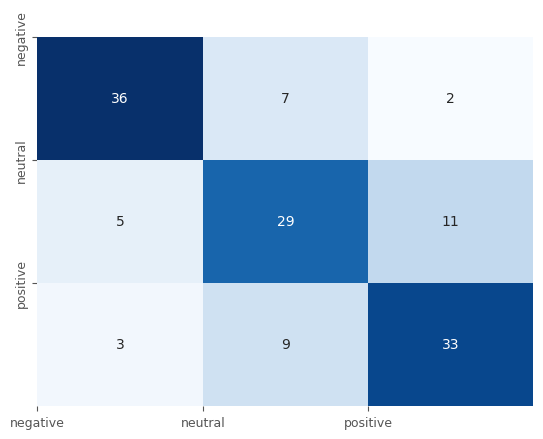

In [ ]:
labels = ['negative', 'neutral', 'positive']
preds = [np.argmax(i) for i in model.predict(x_val_pad)]

cm  = confusion_matrix(y_val.values, preds)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xticks(range(3), labels, fontsize=9)
plt.yticks(range(3), labels, fontsize=9)
plt.show()

Menghitung dan mencetak nilai Recall, Precision, dan Accuracy untuk evaluasi performa model klasifikasi sentimen pada data validasi menggunakan metode micro-averaging.

In [ ]:
print("Recall : {}".format(recall_score(y_val.values, preds, average='micro')))
print("Precision : {}".format(precision_score(y_val.values, preds, average='micro')))
print("Accuracy : {}".format(accuracy_score(y_val.values, preds)))

Recall : 0.725925925925926
Precision : 0.725925925925926
Accuracy : 0.725925925925926


## Pre-Deployment

In [ ]:
with open('word-dict.json', 'w') as file:
  json.dump(tokenizer.word_index, file)

Kode ini digunakan untuk menyimpan kamus indeks kata-kata ke dalam sebuah file JSON bernama word-dict. Kamus ini digunakan untuk melakukan pemrosesan teks pada data yang baru.

In [ ]:
# Specifies the model directory
model_dir = '/tmp/saved_model'
try:
  os.mkdir(model_dir)
except OSError as e:
  print("\nUnable create directory. {}".format(e))

kemudian kita akan membuat sebuah folder yang bernama saved_model.

In [ ]:
# Save model with saved_model format
model_version = 1
save_path = os.path.join(model_dir, str(model_version))

# Gunakan save_model untuk menyimpan model
tf.keras.models.save_model(model, save_path, save_format="tf")

Lalu, kode diatas digunakan untuk menyimpan model dalam folder saved_model.

In [ ]:
!zip -r /tmp/saved_model.zip /tmp/saved_model

Selanjutnya folder saved_model tersebut dijadikan zip.

In [ ]:
from google.colab import files
# Download model
files.download('/tmp/saved_model.zip')

print('`saved_model.zip` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`saved_model.zip` has been downloaded


dengan kode diatas folder saved_model.zip akan di download

## Test Prediction

### in program

In [ ]:
def test_model(text):

  labels = ['negative', 'neutral', 'positive']

  test_pad = pad_sequences(
      tokenizer.texts_to_sequences(text),
      padding=padding_type,
      maxlen=maxlen
  )

  test_prediction = model.predict(test_pad)
  list_test = labels[np.argmax(test_prediction)]

  print(
      "[text] : {}\n[topic] : {}".format(text[0], list_test)
  )

In [ ]:
test_model(['tempatnya nyaman, abangnya ramah, makanannya enak, bakal langganan terus sih'])
test_model(['rasanya biasa aja'])
test_model(['abangnya jorok, makanannya tidak higenis, jijik'])

1/1 [==============================] - 0s 40ms/step
[text] : tempatnya nyaman, abangnya ramah, makanannya enak, bakal langganan terus sih
[topic] : positive
1/1 [==============================] - 0s 16ms/step
[text] : rasanya biasa aja
[topic] : neutral
1/1 [==============================] - 0s 15ms/step
[text] : abangnya jorok, makanannya tidak higenis, jijik
[topic] : negative


Pada bagian ini kami melakukan test terhadap model yang telah kami buat, dapat dilihat bahwa model yang kami buat telah berhasil memberikan prediksi yang sesuai terhadap ulasan yang telah kami berikan.

### in TFServing with CloudRun (GCP)

In [ ]:
import json
import string
import tensorflow as tf
import numpy as np
import requests

In [ ]:
with open("word-dict.json") as file:
    global word_dict
    word_dict = json.load(file)

Kode diatas digunakan untuk mengambil file json dan akan disimpan dalam variabel word_dict. File word_dict disini akan menjadi sebuah kamus di mana setiap kata memiliki nilai tertentu atau metrik yang dapat digunakan untuk analisis sentimen.

In [ ]:
def text_preprocessing(text, dict_word, oov_token="<OOV>", max_length=73):
    words = text.translate(str.maketrans('', '', string.punctuation)).lower().split(" ")
    result = [dict_word.get(word, dict_word[oov_token]) for word in words]
    padding = [0 for _ in range(max_length - len(result))]
    return [result + padding]

In [ ]:
def test_predict_tfserving(text, endpoint):
    text_processed = text_preprocessing(text, dict_word=word_dict)

    json_data = json.dumps({"instances": text_processed})

    response = requests.post(endpoint, data=json_data)
    prediction = response.json()["predictions"][0]
    print(f"Prediction from TFServing: {prediction}")

    list_class_name = ["negative", "neutral", "positive"]

    index_class_predicted = np.argmax(prediction)
    print(f"Index class predicted: {index_class_predicted}")
    print(f"Class name predicted: {list_class_name[index_class_predicted]}")

Pada bagian berisi fungsi yang dapat digunakan untuk menguji atau memprediksi kelas sentimen dari suatu teks menggunakan model yang telah di-deploy menggunakan TensorFlow Serving (TFServing)

In [ ]:
test_predict_tfserving(
    text="lumayan sih rasanya, cuma isinya dikit",
    endpoint="https://kulinerin-app-q6za24kwsq-uc.a.run.app/v1/models/kulinerin-app:predict"
)

Prediction from TFServing: [0.305654734, 0.577717841, 0.11662741]
Index class predicted: 1
Class name predicted: neutral


Selanjutnya kami mencoba fungsi test_predict_tfserving dengan memberikan contoh ulasan yang ingin diprediksi dan memberikan endpoint url yang telah kami dapatkan ketika mendeploy menggunakan Google Cloud Run.